We have used feed-forward connections at the moment. In this notebook, we will show using [PyNN](http://neuralensemble.org/docs/PyNN/index.html) how population of randomly connected recurrent network may exhibit different modes of spontaneous activity.

This follows the work from 

 Brunel N (2000) Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons. J Comput Neurosci 8:183-208

and the implementation @ https://github.com/NeuralEnsemble/PyNN/blob/master/examples/brunel.py 

In [1]:
import numpy as np

In [2]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution, NumpyRNG

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/usr/local/lib/python3.7/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


# defining a Random Recurrent Neural Network


In [3]:
# Parameters determining model dynamics, cf Brunel (2000), Figs 7, 8 and Table 1
# here: Case C, asynchronous irregular firing, ~35 Hz
g           = 7.0     # rel strength of inhibitory synapses
J           = 0.2     # synaptic weight [mV]
eta         = 2.0     # rel rate of external input


In [4]:
# here: Case C, asynchronous irregular firing, ~35 Hz
g           = 2.0     # rel strength of inhibitory synapses
J           = 0.2     # synaptic weight [mV]
eta         = 2.0     # rel rate of external input


In [ ]:
# here: Case C, asynchronous irregular firing, ~35 Hz
g           = 5.0     # rel strength of inhibitory synapses
J           = 0.2     # synaptic weight [mV]
eta         = 2.0     # rel rate of external input


In [ ]:
# === Define parameters ========================================================

downscale   = 50      # scale number of neurons down by this factor
                      # scale synaptic weights up by this factor to
                      # obtain similar dynamics independent of size
order       = 50000  # determines size of network:
                      # 4*order excitatory neurons
                      # 1*order inhibitory neurons
Nrec        = 500      # number of neurons to record from, per population
epsilon     = 0.1     # connectivity: proportion of neurons each neuron projects to

delay       = 1.5     # synaptic delay, all connections [ms]

# single neuron parameters
tauMem      = 20.0    # neuron membrane time constant [ms]
tauSyn      = 0.1     # synaptic time constant [ms]
tauRef      = 2.0     # refractory time [ms]
U0          = 0.0     # resting potential [mV]
theta       = 20.0    # threshold

# simulation-related parameters
simtime     = 500.0   # simulation time [ms]
dt          = 0.1     # simulation step length [ms]

# seed for random generator used when building connections
connectseed = 12345789
use_RandomArray = True # use Python rng rather than NEST rng

# seed for random generator(s) used during simulation
kernelseed  = 42

# === Calculate derived parameters =============================================

# scaling: compute effective order and synaptic strength
order_eff = int(float(order)/downscale)
J_eff     = J*downscale

# compute neuron numbers
NE = int(4*order_eff)  # number of excitatory neurons
NI = int(1*order_eff)  # number of inhibitory neurons
N  = NI + NE           # total number of neurons

# compute synapse numbers
CE   = int(epsilon*NE)  # number of excitatory synapses on neuron
CI   = int(epsilon*NI)  # number of inhibitory synapses on neuron
C    = CE + CI          # total number of internal synapses per n.
Cext = CE               # number of external synapses on neuron

# synaptic weights, scaled for alpha functions, such that
# for constant membrane potential, charge J would be deposited
fudge = 0.00041363506632638 # ensures dV = J at V=0

# excitatory weight: JE = J_eff / tauSyn * fudge
JE = (J_eff/tauSyn)*fudge

# inhibitory weight: JI = - g * JE
JI = -g*JE

# threshold, external, and Poisson generator rates:
nu_thresh = theta/(J_eff*CE*tauMem)
nu_ext    = eta*nu_thresh     # external rate per synapse
p_rate    = 1000*nu_ext*Cext  # external input rate per neuron (Hz)

# number of synapses---just so we know
Nsyn = (C+1)*N + 2*Nrec  # number of neurons * (internal synapses + 1 synapse from PoissonGenerator) + 2synapses" to spike detectors

# put cell parameters into a dict
cell_params = {'tau_m'      : tauMem,
               'tau_syn_E'  : tauSyn,
               'tau_syn_I'  : tauSyn,
               'tau_refrac' : tauRef,
               'v_rest'     : U0,
               'v_reset'    : U0,
               'v_thresh'   : theta,
               'cm'         : 0.001}     # (nF)

In [ ]:
# === Build the network ========================================================
sim.setup(timestep=dt)
from pyNN.utility import Timer
timer = Timer()
timer.start() # start timer on construction

celltype = sim.IF_curr_alpha(**cell_params)
E_net = sim.Population(NE, celltype, label="E_net")
I_net = sim.Population(NI, celltype, label="I_net")

rng = NumpyRNG(kernelseed)
uniformDistr = RandomDistribution('uniform', low=U0, high=theta, rng=rng)
E_net.initialize(v=uniformDistr)
I_net.initialize(v=uniformDistr)

#print "%d Creating excitatory Poisson generator with rate %g spikes/s." % (rank, p_rate)
source_type = sim.SpikeSourcePoisson(rate=p_rate)
expoisson = sim.Population(NE, source_type, label="expoisson")

#print "%d Creating inhibitory Poisson generator with the same rate." % rank
inpoisson = sim.Population(NI, source_type, label="inpoisson")

# Record spikes
#print "%d Setting up recording in excitatory population." % rank
E_net.sample(Nrec).record('spikes')
E_net[0:2].record('v')

#print "%d Setting up recording in inhibitory population." % rank
I_net.sample(Nrec).record('spikes')
I_net[0:2].record('v')

connector = sim.FixedProbabilityConnector(epsilon, rng=rng)
E_syn = sim.StaticSynapse(weight=JE, delay=delay)
I_syn = sim.StaticSynapse(weight=JI, delay=delay)
ext_Connector = sim.OneToOneConnector()
ext_syn = sim.StaticSynapse(weight=JE, delay=dt)

#print "%d Connecting excitatory population with connection probability %g, weight %g nA and delay %g ms." % (rank, epsilon, JE, delay)
E_to_E = sim.Projection(E_net, E_net, connector, E_syn, receptor_type="excitatory")
#print "E --> E\t\t", len(E_to_E), "connections"
I_to_E = sim.Projection(I_net, E_net, connector, I_syn, receptor_type="inhibitory")
#print "I --> E\t\t", len(I_to_E), "connections"
input_to_E = sim.Projection(expoisson, E_net, ext_Connector, ext_syn, receptor_type="excitatory")
#print "input --> E\t", len(input_to_E), "connections"

#print "%d Connecting inhibitory population with connection probability %g, weight %g nA and delay %g ms." % (rank, epsilon, JI, delay)
E_to_I = sim.Projection(E_net, I_net, connector, E_syn, receptor_type="excitatory")
print("E --> I\t\t", len(E_to_I), "connections")
I_to_I = sim.Projection(I_net, I_net, connector, I_syn, receptor_type="inhibitory")
print("I --> I\t\t", len(I_to_I), "connections")
input_to_I = sim.Projection(inpoisson, I_net, ext_Connector, ext_syn, receptor_type="excitatory")
print("input --> I\t", len(input_to_I), "connections")

# read out time used for building
buildCPUTime = timer.elapsedTime()

E --> I		 400116 connections
I --> I		 99808 connections
input --> I	 1000 connections


In [ ]:
# === Run simulation ===========================================================

# run, measure computer time
timer.start() # start timer on construction
print("Running simulation for %g ms." % (simtime))
sim.run(simtime)
simCPUTime = timer.elapsedTime()


E_rate = E_net.mean_spike_count()*1000.0/simtime
I_rate = I_net.mean_spike_count()*1000.0/simtime

# write a short report
print("\n--- Brunel Network Simulation ---")
print("Number of Neurons  : %d" % N)
print("Number of Synapses : %d" % Nsyn)
print("Input firing rate  : %g" % p_rate)
print("Excitatory weight  : %g" % JE)
print("Inhibitory weight  : %g" % JI)
print("Excitatory rate    : %g Hz" % E_rate)
print("Inhibitory rate    : %g Hz" % I_rate)
print("Build time         : %g s" % buildCPUTime)
print("Simulation time    : %g s" % simCPUTime)

# === Clean up and quit ========================================================
sim.end()

Running simulation for 500 ms.

--- Brunel Network Simulation ---
Number of Neurons  : 5000
Number of Synapses : 2506000
Input firing rate  : 200
Excitatory weight  : 0.0413635
Inhibitory weight  : -0.206818
Excitatory rate    : 73.856 Hz
Inhibitory rate    : 70.848 Hz
Build time         : 19.6155 s
Simulation time    : 13.5361 s


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig_width = 15
phi = (np.sqrt(5)+1)/2

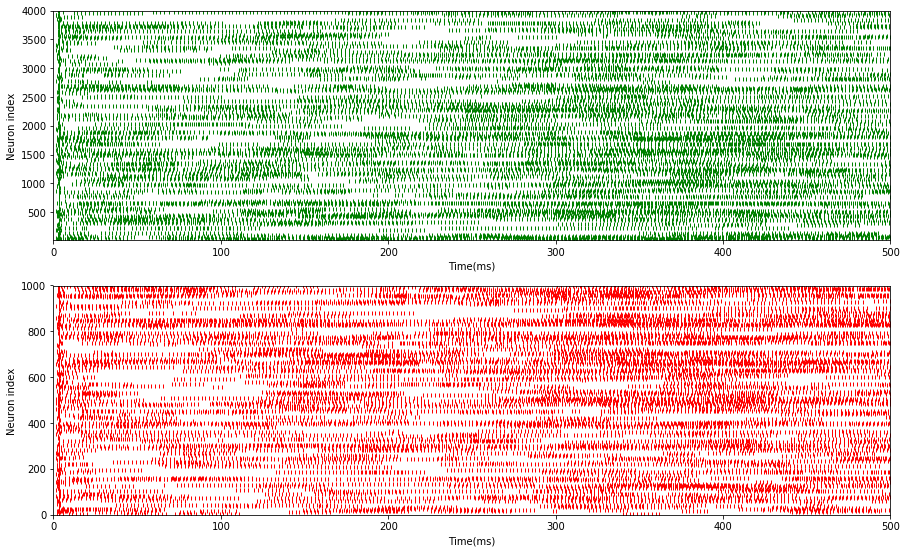

In [ ]:
from tools import plot_spiketrains
fig, axs = plt.subplots(2, 1, figsize=(fig_width, fig_width/phi))
fig, axs[0] = plot_spiketrains(E_net, color='g', simtime=simtime, fig=fig, ax=axs[0])
fig, axs[1] = plot_spiketrains(I_net, color='r', simtime=simtime, fig=fig, ax=axs[1])

# scanning parameters

In [ ]:
def brunel(eta         = 2.0,    # rel rate of external input
           g           = 15.0,     # rel strength of inhibitory synapses
           J           = 10.0     # synaptic weight [mV]
):

    # === Define parameters ========================================================

    downscale   = 50      # scale number of neurons down by this factor
                          # scale synaptic weights up by this factor to
                          # obtain similar dynamics independent of size
    order       = 50000  # determines size of network:
                          # 4*order excitatory neurons
                          # 1*order inhibitory neurons
    Nrec        = 50      # number of neurons to record from, per population
    epsilon     = 0.1     # connectivity: proportion of neurons each neuron projects to

    # Parameters determining model dynamics, cf Brunel (2000), Figs 7, 8 and Table 1
    delay       = 1.5     # synaptic delay, all connections [ms]

    # single neuron parameters
    tauMem      = 20.0    # neuron membrane time constant [ms]
    tauSyn      = 0.1     # synaptic time constant [ms]
    tauRef      = 2.0     # refractory time [ms]
    U0          = 0.0     # resting potential [mV]
    theta       = 20.0    # threshold

    # simulation-related parameters
    simtime     = 500.0   # simulation time [ms]
    dt          = 0.1     # simulation step length [ms]

    # seed for random generator used when building connections
    connectseed = 12345789
    use_RandomArray = True # use Python rng rather than NEST rng

    # seed for random generator(s) used during simulation
    kernelseed  = 42

    # === Calculate derived parameters =============================================

    # scaling: compute effective order and synaptic strength
    order_eff = int(float(order)/downscale)
    J_eff     = J*downscale

    # compute neuron numbers
    NE = int(4*order_eff)  # number of excitatory neurons
    NI = int(1*order_eff)  # number of inhibitory neurons
    N  = NI + NE           # total number of neurons

    # compute synapse numbers
    CE   = int(epsilon*NE)  # number of excitatory synapses on neuron
    CI   = int(epsilon*NI)  # number of inhibitory synapses on neuron
    C    = CE + CI          # total number of internal synapses per n.
    Cext = CE               # number of external synapses on neuron

    # synaptic weights, scaled for alpha functions, such that
    # for constant membrane potential, charge J would be deposited
    fudge = 0.00041363506632638 # ensures dV = J at V=0

    # excitatory weight: JE = J_eff / tauSyn * fudge
    JE = (J_eff/tauSyn)*fudge

    # inhibitory weight: JI = - g * JE
    JI = -g*JE

    # threshold, external, and Poisson generator rates:
    nu_thresh = theta/(J_eff*CE*tauMem)
    nu_ext    = eta*nu_thresh     # external rate per synapse
    p_rate    = 1000*nu_ext*Cext  # external input rate per neuron (Hz)

    # number of synapses---just so we know
    Nsyn = (C+1)*N + 2*Nrec  # number of neurons * (internal synapses + 1 synapse from PoissonGenerator) + 2synapses" to spike detectors

    # put cell parameters into a dict
    cell_params = {'tau_m'      : tauMem,
                   'tau_syn_E'  : tauSyn,
                   'tau_syn_I'  : tauSyn,
                   'tau_refrac' : tauRef,
                   'v_rest'     : U0,
                   'v_reset'    : U0,
                   'v_thresh'   : theta,
                   'cm'         : 0.001}     # (nF)

    # === Build the network ========================================================
    sim.setup(timestep=dt)
    from pyNN.utility import Timer
    timer = Timer()
    timer.start() # start timer on construction

    celltype = sim.IF_curr_alpha(**cell_params)
    E_net = sim.Population(NE, celltype, label="E_net")
    I_net = sim.Population(NI, celltype, label="I_net")

    rng = NumpyRNG(kernelseed)
    uniformDistr = RandomDistribution('uniform', low=U0, high=theta, rng=rng)
    E_net.initialize(v=uniformDistr)
    I_net.initialize(v=uniformDistr)

    #print "%d Creating excitatory Poisson generator with rate %g spikes/s." % (rank, p_rate)
    source_type = sim.SpikeSourcePoisson(rate=p_rate)
    expoisson = sim.Population(NE, source_type, label="expoisson")

    #print "%d Creating inhibitory Poisson generator with the same rate." % rank
    inpoisson = sim.Population(NI, source_type, label="inpoisson")

    # Record spikes
    #print "%d Setting up recording in excitatory population." % rank
    E_net.sample(Nrec).record('spikes')
    E_net[0:2].record('v')

    #print "%d Setting up recording in inhibitory population." % rank
    I_net.sample(Nrec).record('spikes')
    I_net[0:2].record('v')

    connector = sim.FixedProbabilityConnector(epsilon, rng=rng)
    E_syn = sim.StaticSynapse(weight=JE, delay=delay)
    I_syn = sim.StaticSynapse(weight=JI, delay=delay)
    ext_Connector = sim.OneToOneConnector()
    ext_syn = sim.StaticSynapse(weight=JE, delay=dt)

    #print "%d Connecting excitatory population with connection probability %g, weight %g nA and delay %g ms." % (rank, epsilon, JE, delay)
    E_to_E = sim.Projection(E_net, E_net, connector, E_syn, receptor_type="excitatory")
    #print "E --> E\t\t", len(E_to_E), "connections"
    I_to_E = sim.Projection(I_net, E_net, connector, I_syn, receptor_type="inhibitory")
    #print "I --> E\t\t", len(I_to_E), "connections"
    input_to_E = sim.Projection(expoisson, E_net, ext_Connector, ext_syn, receptor_type="excitatory")
    #print "input --> E\t", len(input_to_E), "connections"

    #print "%d Connecting inhibitory population with connection probability %g, weight %g nA and delay %g ms." % (rank, epsilon, JI, delay)
    E_to_I = sim.Projection(E_net, I_net, connector, E_syn, receptor_type="excitatory")
    print("E --> I\t\t", len(E_to_I), "connections")
    I_to_I = sim.Projection(I_net, I_net, connector, I_syn, receptor_type="inhibitory")
    print("I --> I\t\t", len(I_to_I), "connections")
    input_to_I = sim.Projection(inpoisson, I_net, ext_Connector, ext_syn, receptor_type="excitatory")
    print("input --> I\t", len(input_to_I), "connections")

    # read out time used for building
    buildCPUTime = timer.elapsedTime()

    # === Run simulation ===========================================================

    # run, measure computer time
    timer.start() # start timer on construction
    print("Running simulation for %g ms." % (simtime))
    sim.run(simtime)
    simCPUTime = timer.elapsedTime()


    E_rate = E_net.mean_spike_count()*1000.0/simtime
    I_rate = I_net.mean_spike_count()*1000.0/simtime

    # write a short report
    print("\n--- Brunel Network Simulation ---")
    print("Number of Neurons  : %d" % N)
    print("Number of Synapses : %d" % Nsyn)
    print("Input firing rate  : %g" % p_rate)
    print("Excitatory weight  : %g" % JE)
    print("Inhibitory weight  : %g" % JI)
    print("Excitatory rate    : %g Hz" % E_rate)
    print("Inhibitory rate    : %g Hz" % I_rate)
    print("Build time         : %g s" % buildCPUTime)
    print("Simulation time    : %g s" % simCPUTime)

    # === Clean up and quit ========================================================
    sim.end()

    from tools import plot_spiketrains
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    fig, ax = plot_spiketrains(E_net, color='g', simtime=simtime, fig=fig, ax=ax)
    return fig, ax

In [ ]:
N_scan = 5

In [ ]:
gs = g * np.logspace(-1, 1, N_scan, base=2)
for g_ in gs:
    fig, ax = brunel(eta=eta, g=g_, J=J)
    plt.show()

In [ ]:
etas = eta*np.logspace(-1, 1, N_scan, base=10)
for eta_ in etas:
    fig, ax = brunel(eta=eta, g=g, J=J)
    plt.show()    

In [ ]:
Js = J*np.logspace(-1, 1, N_scan, base=10)
for J_ in Js:
    fig, ax = brunel(eta=eta, g=g, J=J_)
    plt.show()    